In [103]:
!pip3 install matplotlib==3.7.2
!pip3 install tqdm
!pip3 install plotly
!pip3 install pandas==1.3.4
!pip3 install pyarrow

In [104]:
from non_parametric_tests import NonParametricTests

In [105]:
import os
import s3fs
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.sql.window import *

spark = SparkSession.builder.getOrCreate()
s3 = s3fs.S3FileSystem(anon=False)

In [106]:
class WriteReader:
    def __init__(self, base_path):
        self.base_path = base_path

    def write_and_read(self, df, name):
        path = os.path.join(self.base_path, name)
        df.write.mode("Overwrite").format("parquet").save(path)
        df = spark.read.format("parquet").load(path)
        return df

    def read(self, name):
        path = os.path.join(self.base_path, name)
        df = spark.read.format("parquet").load(path)
        return df

def ls(path):
    display(dbutils.fs.ls(path))
def rm(path):
    dbutils.fs.rm(path, True)

path = "s3://pa-ai-datascience-storage-dev/users/ub/edgar.davtyan/Tasks/Research on AI Gen/Interleaving/PackageScripts/TestData/"

write_reader_parquet = WriteReader(path)
write_reader_delta   = WriteReader(path)

wr = write_reader_parquet.write_and_read
rr = write_reader_parquet.read

In [107]:
ai_apply_click_aa = rr("sample_data_apply_click_aa").select("sid", "keyword", "time_hours", "photo_id")
ai_apply_click = rr("sample_data_apply_click")
sid=["sid", "keyword"]
grouping="time_hours"

In [108]:
NonParametricTests_tester = NonParametricTests(sid_columns=sid,
                         grouping_column=grouping,
                         treatment_variant="stable_diffusion_v22",
                         control_variant="stable_diffusion_v21",
                         item_id_column="photo_id",
                         variant_column="sd_version")

In [109]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [110]:
NonParametricTests_tester.transform(ai_apply_click)

View job details at https://picsart-dev.cloud.databricks.com/?o=0#/setting/clusters/0219-083901-krfv8a0u/sparkUi


View job details at https://picsart-dev.cloud.databricks.com/?o=0#/setting/clusters/0219-083901-krfv8a0u/sparkUi
23/10/12 16:56:22 WARN SparkServiceRPCClient: Large server response (4239759 bytes compressed)


In [111]:
NonParametricTests_tester.tr_data.shape, NonParametricTests_tester.ctr_data.shape

((16962, 1), (14336, 1))

In [112]:
results_permutation = NonParametricTests_tester.run_test(test_type='permutation', n_resamples=10**3)

In [113]:
results_permutation

{'null_distribution': array([[-2.71036519e-03],
        [ 3.59641385e-03],
        [ 1.02221832e-03],
        [-5.02714116e-03],
        [-1.16584787e-03],
        [ 6.42802892e-03],
        [ 4.62609206e-03],
        [ 9.00222444e-03],
        [ 1.79447698e-03],
        [-3.61133362e-03],
        [ 1.15092810e-03],
        [-1.03042420e-02],
        [ 4.11125295e-03],
        [ 1.79447698e-03],
        [-6.51008767e-04],
        [-1.93810653e-03],
        [-7.98746601e-03],
        [ 5.78448004e-03],
        [ 1.53705743e-03],
        [ 1.92318676e-03],
        [ 2.82415519e-03],
        [ 3.59641385e-03],
        [-9.27456377e-03],
        [-3.74004340e-03],
        [-3.35391407e-03],
        [ 6.55673870e-03],
        [ 7.71512668e-03],
        [-3.09649451e-03],
        [-1.36169663e-04],
        [-6.51008767e-04],
        [ 9.90319288e-03],
        [-4.12617272e-03],
        [-1.08190811e-02],
        [ 2.69544541e-03],
        [-5.41327049e-03],
        [-9.91811265e-03],
       

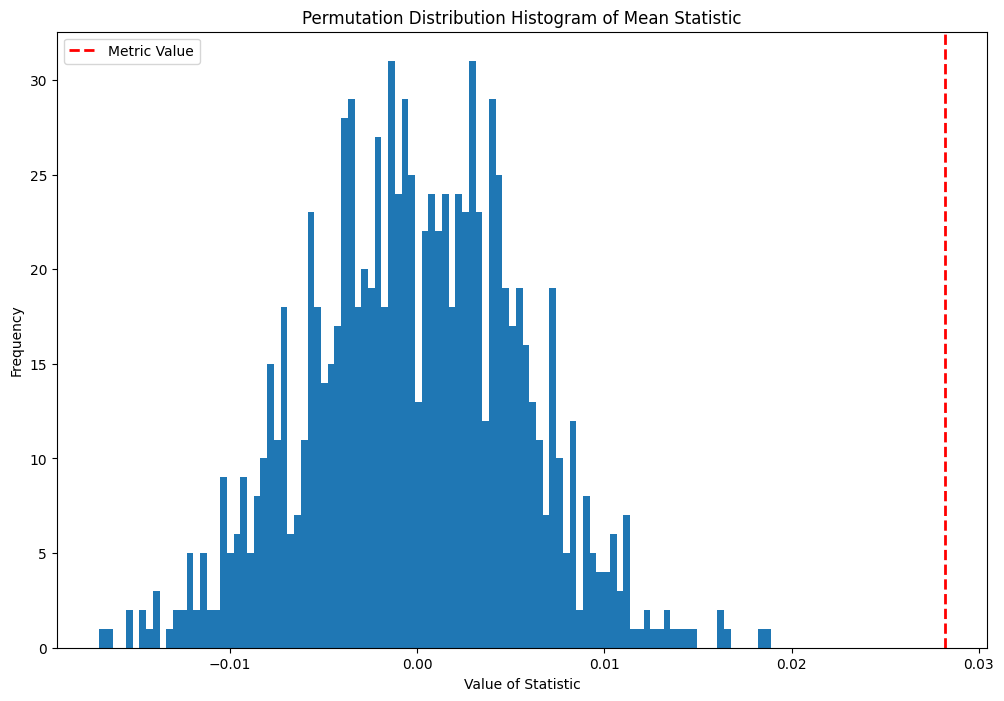

In [32]:
NonParametricTests_tester.visualize(results_permutation, test_type='permutation')

In [39]:
results_bootstrap = NonParametricTests_tester.run_test(test_type='bootstrap', n_resamples=10**1)

In [40]:
results_bootstrap

{'bootstrap_distribution': array([[0.02014246, 0.03071218, 0.03548492, 0.03585089, 0.02830373,
         0.03138749, 0.03460235, 0.02949452, 0.01591112, 0.02918046]]),
 'confidence_interval': ConfidenceInterval(low=array([0.01591631]), high=array([0.03103818])),
 'standard_error': array([0.00649298]),
 'statistic': 0.028179981092189443}

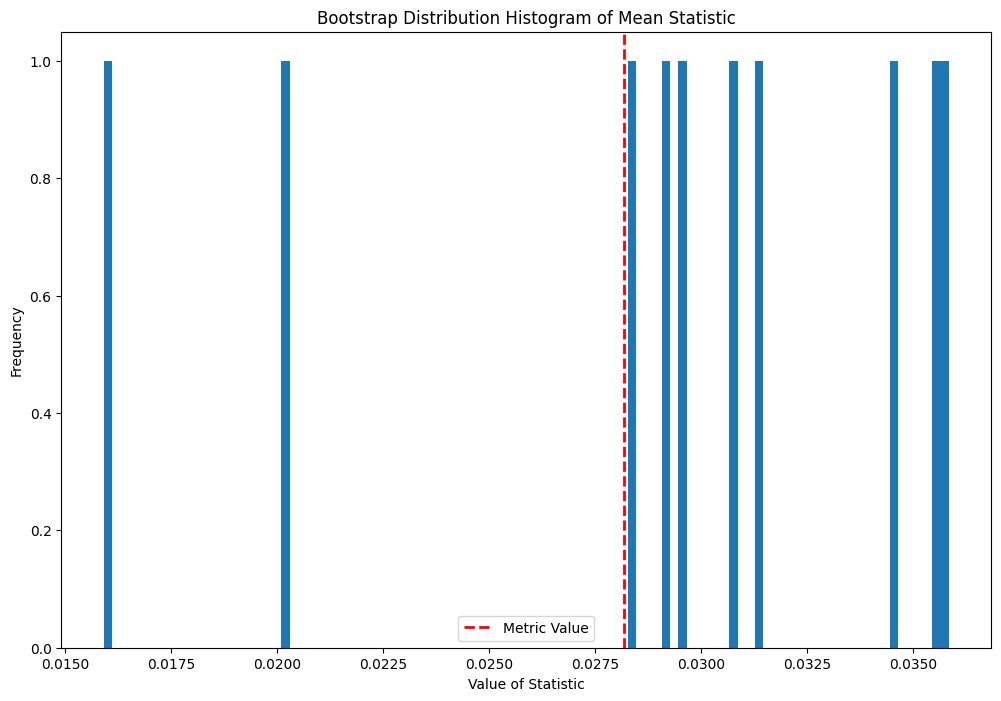

In [41]:
NonParametricTests_tester.visualize(results_bootstrap, test_type='bootstrap')

In [ ]:
 # results_bootstrap["bootstrap_distribution"] = results_bootstrap["bootstrap_distribution"][0]

Testing test functions

In [136]:
# Fixing the random seed for reproducibility
np.random.seed(42)
# Parameters
start_time = pd.Timestamp("2023-06-05 06:00:00")
end_time = pd.Timestamp("2023-06-05 23:00:00")
mean_rows_per_hour = 1150
stddev_rows_per_hour = 240
unique_sids = 2000  # Number of unique sid_1 and sid_2 identifiers
p_A = 0.45  # Probability of selecting variant A

# Generate consecutive hours
hours = pd.date_range(start=start_time, end=end_time, freq='H')

# Generate unique sid_1 and sid_2 identifiers
sid_1 = np.random.randint(100, 1000, size=unique_sids)
sid_2 = np.random.randint(1000, 2000, size=unique_sids)

# Initialize DataFrame
simulated_data = pd.DataFrame(columns=['hours', 'sid_1', 'sid_2', 'item_id', 'variant'])

# Start item_id from a 15-digit number
item_id_start = 10 ** 14

# Generate data for each hour
for hour in hours:
    # Generate number of rows for the current hour using a normal distribution
    num_rows = int(np.random.normal(loc=mean_rows_per_hour, scale=stddev_rows_per_hour))

    # Create DataFrame for the current hour
    current_data = pd.DataFrame({
        'hours': [hour] * num_rows,
        'sid_1': np.random.choice(sid_1, num_rows),
        'sid_2': np.random.choice(sid_2, num_rows),
        'item_id': np.arange(item_id_start, item_id_start + num_rows),
        'variant': np.random.choice(['A', 'B'], num_rows, p=[p_A, 1 - p_A])
    })

    # Append to the main DataFrame
    simulated_data = pd.concat([simulated_data, current_data], ignore_index=True)

    # Update item_id_start for uniqueness in the next iteration
    item_id_start += num_rows

# Convert the Pandas DataFrame to a Spark DataFrame
simulated_data_spark = spark.createDataFrame(simulated_data)

In [135]:
simulated_data_spark.groupby("variant", "hours").count().orderBy("hours", "variant").show()

View job details at https://picsart-dev.cloud.databricks.com/?o=0#/setting/clusters/0219-083901-krfv8a0u/sparkUi
+-------+-------------------+-----+
|variant|              hours|count|
+-------+-------------------+-----+
|      A|2023-06-05 06:00:00|  563|
|      B|2023-06-05 06:00:00|  365|
|      A|2023-06-05 07:00:00|  773|
|      B|2023-06-05 07:00:00|  497|
|      A|2023-06-05 08:00:00|  986|
|      B|2023-06-05 08:00:00|  592|
|      A|2023-06-05 09:00:00|  671|
|      B|2023-06-05 09:00:00|  482|
|      A|2023-06-05 10:00:00|  676|
|      B|2023-06-05 10:00:00|  426|
|      A|2023-06-05 11:00:00|  706|
|      B|2023-06-05 11:00:00|  459|
|      A|2023-06-05 12:00:00|  603|
|      B|2023-06-05 12:00:00|  400|
|      A|2023-06-05 13:00:00|  691|
|      B|2023-06-05 13:00:00|  484|
|      A|2023-06-05 14:00:00|  880|
|      B|2023-06-05 14:00:00|  596|
|      A|2023-06-05 15:00:00|  597|
|      B|2023-06-05 15:00:00|  426|
+-------+-------------------+-----+
only showing top 20 row

In [137]:
tester = NonParametricTests(
        sid_columns=['sid_1', 'sid_2'],
        grouping_column='hours',
        treatment_variant='A',
        control_variant='B'
    )

# Perform the transform method
tester.transform(simulated_data_spark)

View job details at https://picsart-dev.cloud.databricks.com/?o=0#/setting/clusters/0219-083901-krfv8a0u/sparkUi


View job details at https://picsart-dev.cloud.databricks.com/?o=0#/setting/clusters/0219-083901-krfv8a0u/sparkUi


In [138]:
result = tester.run_test(test_type='permutation')

In [144]:
isinstance(result['within_ci'], np.bool_)

True

In [141]:
type(result['within_ci'])

numpy.bool_

In [145]:
result = tester.run_test(test_type='bootstrap')

In [146]:
result

{'bootstrap_distribution': array([[-0.00258011, -0.00274723,  0.00183998, ..., -0.00100141,
          0.00074429, -0.00174427]]),
 'confidence_interval': ConfidenceInterval(low=array([-0.0038395]), high=array([0.0024566])),
 'standard_error': array([0.00161049]),
 'statistic': -0.000722917894033781}